In [ ]:
path2 = '/content/drive/My Drive/Colab Notebooks/pha.csv'

In [ ]:
import matplotlib
from tqdm import tqdm

import pandas as pd
import datetime
import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import seaborn as sns
from google.colab import drive
from pandas.plotting import scatter_matrix
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_tmp = pd.read_csv(path2, nrows=901, parse_dates =['time'], keep_date_col = True)
df_tmp

,time,Winterthur,Büdingen,Schondorf,Herzogenrath,Bremen,Dresden,Lleida,Sibiu,Belfort Cedex,Wien (SBA)
0,2019-09-01 00:00:00,NaN,305,152,6,NaN,194,43,164,177,NaN
1,2019-09-01 00:00:01,NaN,303,150,6,NaN,193,43,163,176,NaN
2,2019-09-01 00:00:02,NaN,301,148,5,NaN,191,41,161,174,NaN
3,2019-09-01 00:00:03,NaN,299,145,2,NaN,188,38,158,171,NaN
4,2019-09-01 00:00:04,NaN,295,142,360,NaN,184,36,155,168,NaN
...,...,...,...,...,...,...,...,...,...,...,...
896,2019-09-01 00:14:56,NaN,253,101,318,NaN,141,357,123,128,NaN
897,2019-09-01 00:14:57,NaN,251,99,315,NaN,139,355,121,126,NaN
898,2019-09-01 00:14:58,NaN,249,97,313,NaN,137,353,119,124,NaN
899,2019-09-01 00:14:59,NaN,248,96,311,NaN,136,351,118,122,NaN


In [ ]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time           901 non-null    datetime64[ns]
 1   Winterthur     0 non-null      float64       
 2   Büdingen       901 non-null    int64         
 3   Schondorf      901 non-null    int64         
 4   Herzogenrath   901 non-null    int64         
 5   Bremen         0 non-null      float64       
 6   Dresden        901 non-null    int64         
 7   Lleida         901 non-null    int64         
 8   Sibiu          901 non-null    int64         
 9   Belfort Cedex  901 non-null    int64         
 10  Wien (SBA)     0 non-null      float64       
dtypes: datetime64[ns](1), float64(3), int64(7)
memory usage: 77.6 KB


In [ ]:
missing_val = (df_tmp.isna().sum())
print(missing_val)


time               0
Winterthur       901
Büdingen           0
Schondorf          0
Herzogenrath       0
Bremen           901
Dresden            0
Lleida             0
Sibiu              0
Belfort Cedex      0
Wien (SBA)       901
dtype: int64


In [ ]:
df_tmp = df_tmp.set_index(['time'])  

df_tmp['phase_diff'] = df_tmp['Herzogenrath'] - df_tmp['Schondorf']
df_tmp['angle'] = np.sin(np.deg2rad(df_tmp['phase_diff']))

In [ ]:
#Locations
site1 = "Winterthur"
site2 = "Büdingen"
site3 = "Schondorf"
site4 = "Herzogenrath"
site5 = "Bremen"
site6=  "Dresden"
site7 = "Lleida"
site8 = "Sibiu"
site9 = "Belfort Cedex"
site10 = "Wien (SBA)"

In [ ]:
chunksize = 10000000

In [ ]:
%%time
df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(path2, usecols=("time",site1, site2,site3,site4,site5,site6,site7,site8,site9,site10),parse_dates =['time'], keep_date_col = True, chunksize=chunksize)):
     
    df_chunk = df_chunk.set_index(['time'])
    #df_chunk['time'] = pd.to_datetime(df_chunk['time'], utc=True, format='%Y-%m-%d %H:%M:%S')
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk)
    

# Merge all dataframes into one dataframe
data = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
data.info()

4it [01:11, 17.77s/it]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34214399 entries, 2019-09-01 00:00:00 to 2020-09-30 23:59:58
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Winterthur     float64
 1   Büdingen       float64
 2   Schondorf      float64
 3   Herzogenrath   float64
 4   Bremen         float64
 5   Dresden        float64
 6   Lleida         float64
 7   Sibiu          float64
 8   Belfort Cedex  float64
 9   Wien (SBA)     float64
dtypes: float64(10)
memory usage: 2.8 GB
CPU times: user 50.6 s, sys: 12.1 s, total: 1min 2s
Wall time: 1min 15s


In [ ]:
data.head()


,Winterthur,Büdingen,Schondorf,Herzogenrath,Bremen,Dresden,Lleida,Sibiu,Belfort Cedex,Wien (SBA)
time,,,,,,,,,,
2019-09-01 00:00:00,NaN,305.0,152.0,6.0,NaN,194.0,43.0,164.0,177.0,NaN
2019-09-01 00:00:01,NaN,303.0,150.0,6.0,NaN,193.0,43.0,163.0,176.0,NaN
2019-09-01 00:00:02,NaN,301.0,148.0,5.0,NaN,191.0,41.0,161.0,174.0,NaN
2019-09-01 00:00:03,NaN,299.0,145.0,2.0,NaN,188.0,38.0,158.0,171.0,NaN
2019-09-01 00:00:04,NaN,295.0,142.0,360.0,NaN,184.0,36.0,155.0,168.0,NaN


In [ ]:
data.tail()

,Winterthur,Büdingen,Schondorf,Herzogenrath,Bremen,Dresden,Lleida,Sibiu,Belfort Cedex,Wien (SBA)
time,,,,,,,,,,
2020-09-30 23:59:54,358.0,252.0,321.0,326.0,310.0,132.0,3.0,129.0,105.0,209.0
2020-09-30 23:59:55,348.0,241.0,311.0,316.0,299.0,122.0,352.0,118.0,94.0,199.0
2020-09-30 23:59:56,337.0,231.0,300.0,305.0,289.0,112.0,340.0,108.0,84.0,189.0
2020-09-30 23:59:57,326.0,220.0,290.0,294.0,278.0,101.0,329.0,98.0,73.0,178.0
2020-09-30 23:59:58,315.0,209.0,278.0,283.0,267.0,90.0,318.0,88.0,61.0,167.0


In [ ]:
data.shape


(34214399, 10)

In [ ]:

# start and end dates of the time series
print ("phase angle dataset: start_date = {}, end_date = {} \n".format(data.index.min(), data.index.max()))

phase angle dataset: start_date = 2019-09-01 00:00:00, end_date = 2020-09-30 23:59:58 



In [ ]:
missing_val = (data.isna().sum())
print(missing_val)

Winterthur       18118947
Büdingen             6965
Schondorf          108469
Herzogenrath       382998
Bremen           11015690
Dresden             81291
Lleida              51146
Sibiu               17952
Belfort Cedex      243215
Wien (SBA)        5852146
dtype: int64


In [ ]:
%%time
df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(path2, usecols=("time",site1, site2,site3,site4,site5,site6,site7,site8,site9,site10),parse_dates =['time'], keep_date_col = True, chunksize=chunksize)):
    #We will resample the data to 1 hr to be able to plot; dataset is too large and require additional memory to process

    df_chunk = df_chunk.set_index(['time'])
    df_chunk = df_chunk.resample('1 h').mean()
    
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk)
    

# Merge all dataframes into one dataframe
data_df = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
data_df.info()

4it [01:08, 17.14s/it]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9507 entries, 2019-09-01 00:00:00 to 2020-09-30 23:00:00
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Winterthur     4485 non-null   float64
 1   Büdingen       9507 non-null   float64
 2   Schondorf      9483 non-null   float64
 3   Herzogenrath   9404 non-null   float64
 4   Bremen         6447 non-null   float64
 5   Dresden        9491 non-null   float64
 6   Lleida         9507 non-null   float64
 7   Sibiu          9506 non-null   float64
 8   Belfort Cedex  9444 non-null   float64
 9   Wien (SBA)     7882 non-null   float64
dtypes: float64(10)
memory usage: 817.0 KB
CPU times: user 50 s, sys: 5.8 s, total: 55.8 s
Wall time: 1min 8s


In [ ]:
data_df.shape


(9507, 10)

In [ ]:

missing_val = (data_df.isna().sum())
print(missing_val)

Winterthur       5022
Büdingen            0
Schondorf          24
Herzogenrath      103
Bremen           3060
Dresden            16
Lleida              0
Sibiu               1
Belfort Cedex      63
Wien (SBA)       1625
dtype: int64


CPU times: user 1.97 s, sys: 152 ms, total: 2.12 s
Wall time: 2.05 s


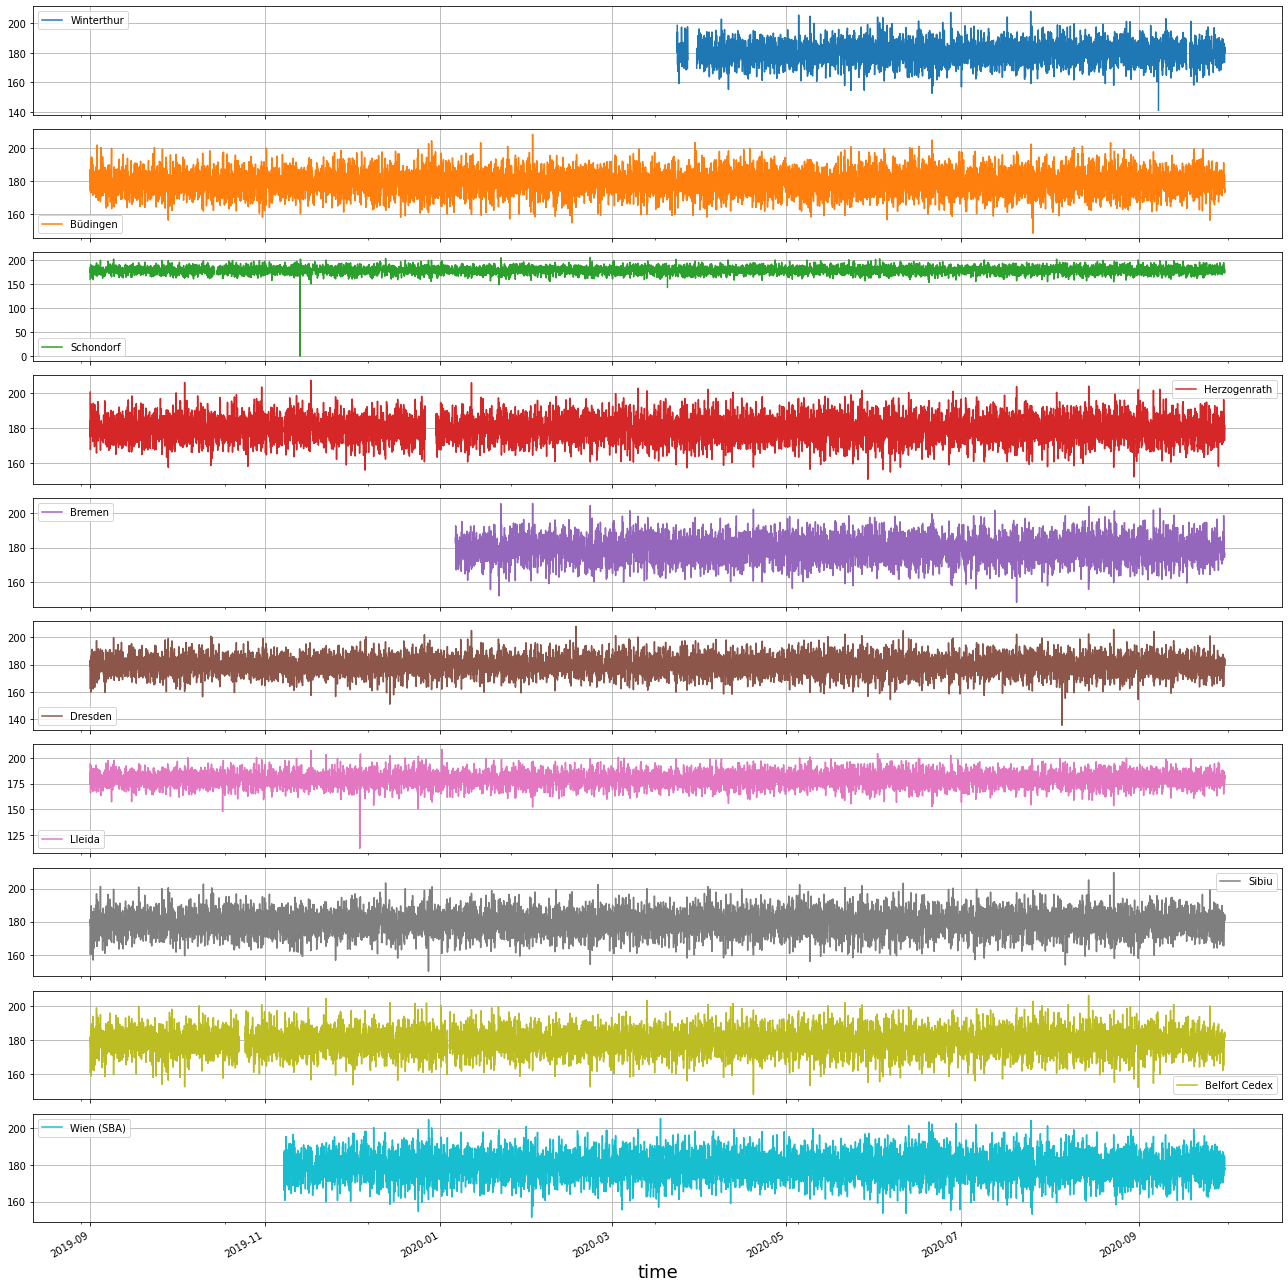

In [ ]:
%%time
data_df.plot(grid=True, subplots=True, figsize=(18,18))
plt.xlabel('time', fontsize=18)
plt.legend(loc='upper left')
plt.tight_layout()

In [ ]:
#Locations chosen for the project
site2 = "Belfort Cedex"
site3 = "Schondorf"
site4 = "Herzogenrath"
site5 = "Bremen"

In [ ]:
df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(path2, usecols=("time",site2,site3,site4,site5),parse_dates =['time'], keep_date_col = True, chunksize=chunksize)):
    #We will resample the data to 1 hr to be able to plot; dataset is too large and require additional memory to process

    df_chunk = df_chunk.set_index(['time'])
    df_chunk = df_chunk.resample('1 h').mean()
    
    # Append the chunk to list and merge all
    df_list.append(df_chunk)
    

# Merge all dataframes into one dataframe
df_data = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
df_data.info()

4it [00:57, 14.28s/it]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9507 entries, 2019-09-01 00:00:00 to 2020-09-30 23:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Schondorf      9483 non-null   float64
 1   Herzogenrath   9404 non-null   float64
 2   Bremen         6447 non-null   float64
 3   Belfort Cedex  9444 non-null   float64
dtypes: float64(4)
memory usage: 371.4 KB


In [ ]:
df_data.shape


(9507, 4)

In [ ]:
# start and end dates of the time series
print ("phase angle dataset: start_date = {}, end_date = {} \n".format(df_data.index.min(), df_data.index.max()))

phase angle dataset: start_date = 2019-09-01 00:00:00, end_date = 2020-09-30 23:00:00 



In [ ]:
missing_val = (df_data.isna().sum())
print(missing_val)

Schondorf          24
Herzogenrath      103
Bremen           3060
Belfort Cedex      63
dtype: int64


CPU times: user 638 ms, sys: 95.9 ms, total: 734 ms
Wall time: 640 ms


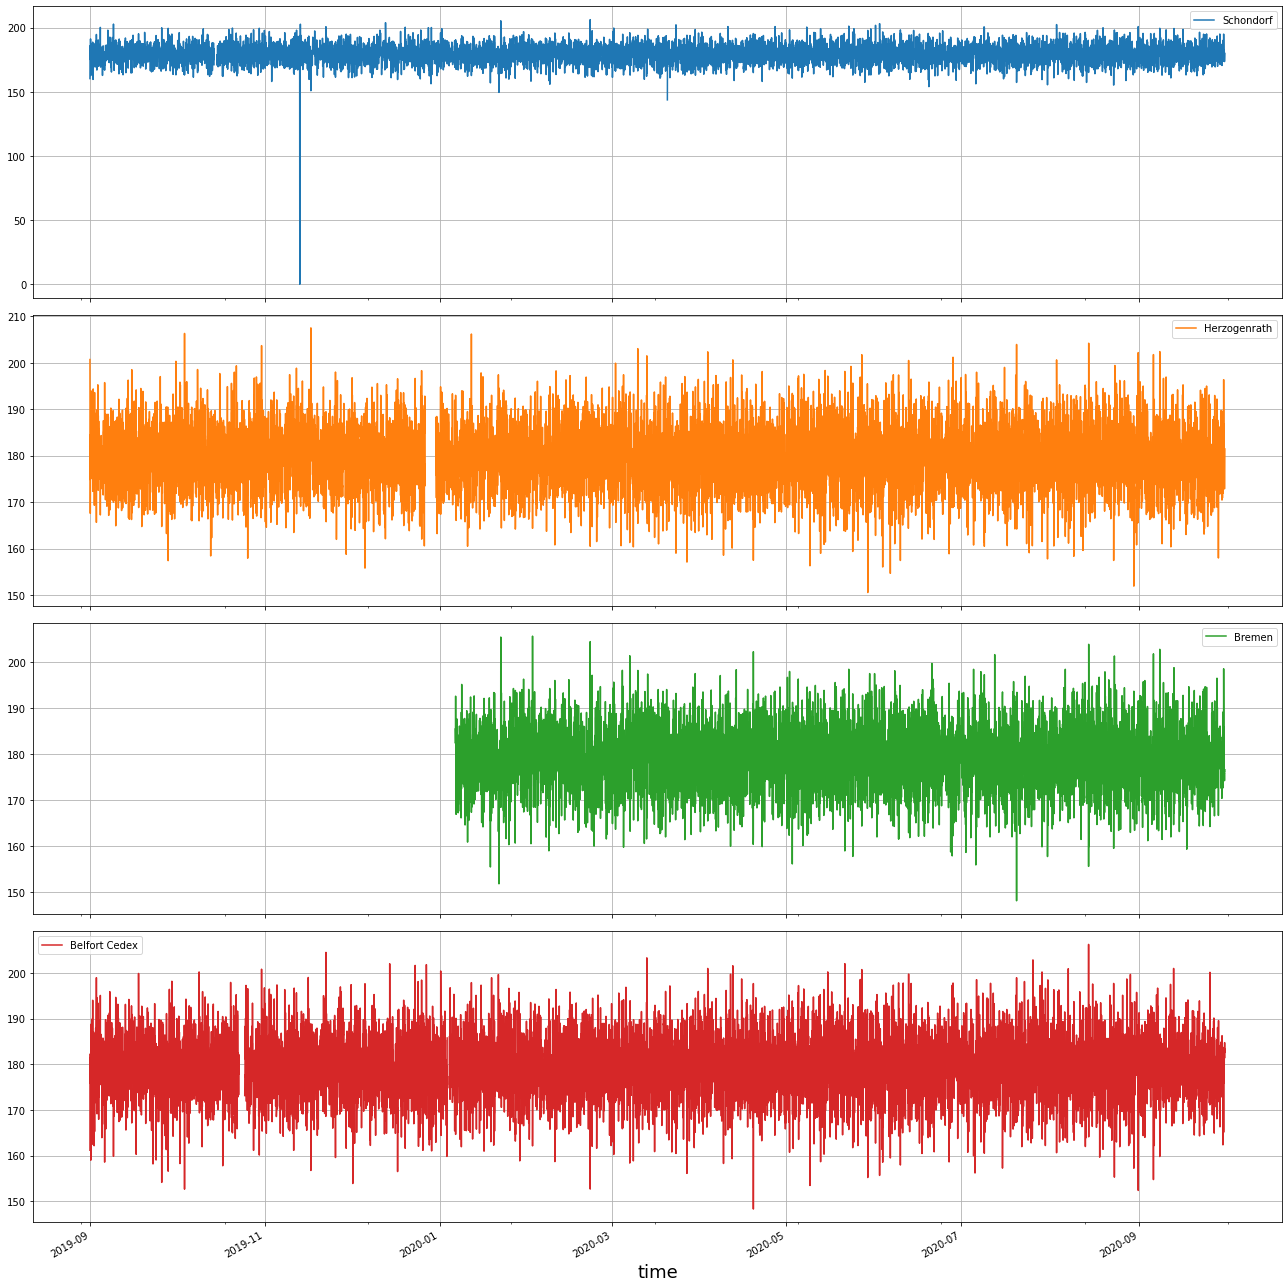

In [ ]:
%%time
df_data.plot(grid=True, subplots=True, figsize=(18,18))
plt.xlabel('time', fontsize=18)
plt.legend(loc='upper left')
plt.tight_layout()

In [ ]:
%%time
df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(path2, usecols=("time",site2,site3,site4,site5),parse_dates =['time'], keep_date_col = True, chunksize=chunksize)):
    
    df_chunk = df_chunk.set_index(['time'])
    df_chunk = df_chunk.rename(columns={'Belfort Cedex':'Belfort_Cedex'})  
    # Can process each chunk of dataframe here
    # clean_data(), pre_process_data()
    
    #df_chunk = df_chunk.assign(Büdingen2=df_chunk.Büdingen.fillna(df_chunk.Büdingen.mean()))
    df_chunk = df_chunk.assign(Belfort_Cedex2=df_chunk.Belfort_Cedex.fillna(df_chunk.Belfort_Cedex.mean()))
    df_chunk = df_chunk.assign(Schondorf2=df_chunk.Schondorf.fillna(df_chunk.Schondorf.mean()))
    df_chunk = df_chunk.assign(Herzogenrath2=df_chunk.Herzogenrath.fillna(df_chunk.Herzogenrath.mean()))
   
    df_chunk['phase_diff1'] = (df_chunk['Belfort_Cedex2'] - df_chunk['Schondorf2'])
    df_chunk['angle1'] = np.sin(np.deg2rad(df_chunk['phase_diff1']))
    
    
    df_chunk['phase_diff2'] = (df_chunk['Belfort_Cedex2'] - df_chunk['Herzogenrath2'])
    df_chunk['angle2'] = np.sin(np.deg2rad(df_chunk['phase_diff2']))
    
    df_chunk['phase_diff3'] = (df_chunk['Belfort_Cedex2'] - df_chunk['Bremen'])
    df_chunk['angle3'] = np.sin(np.deg2rad(df_chunk['phase_diff3']))
    
    #df_chunk['time'] = pd.to_datetime(df_chunk['time'], format='%Y-%m-%d %H:%M:%S')
    df_chunk = df_chunk.resample('1 h').mean()
    #df2_chunk = df2_chunk.set_index(['time'])

    
    # Append the chunk to list and merge all
    df_list.append(df_chunk)

# Merge all dataframes into one dataframe
phasor_data = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list


4it [01:03, 15.86s/it]

CPU times: user 50.9 s, sys: 9.37 s, total: 1min
Wall time: 1min 3s


In [ ]:
phasor_data.shape

(9507, 13)

In [ ]:
print ("phase angle dataset: start_date = {}, end_date = {} \n".format(phasor_data.index.min(), phasor_data.index.max()))

phase angle dataset: start_date = 2019-09-01 00:00:00, end_date = 2020-09-30 23:00:00 



In [ ]:

missing_val = (phasor_data.isna().sum())
print(missing_val)

Schondorf           24
Herzogenrath       103
Bremen            3060
Belfort_Cedex       63
Belfort_Cedex2       0
Schondorf2           0
Herzogenrath2        0
phase_diff1          0
angle1               0
phase_diff2          0
angle2               0
phase_diff3       3060
angle3            3060
dtype: int64


In [ ]:
phasor_data.head()

,Schondorf,Herzogenrath,Bremen,Belfort_Cedex,Belfort_Cedex2,Schondorf2,Herzogenrath2,phase_diff1,angle1,phase_diff2,angle2,phase_diff3,angle3
time,,,,,,,,,,,,,
2019-09-01 00:00:00,160.249722,200.708056,NaN,161.190833,161.190833,160.249722,200.708056,0.941111,0.453009,-39.517222,0.159234,NaN,NaN
2019-09-01 01:00:00,180.340556,174.862778,NaN,181.341944,181.341944,180.340556,174.862778,1.001389,0.464817,6.479167,0.092559,NaN,NaN
2019-09-01 02:00:00,175.168056,184.452500,NaN,179.712778,179.712778,175.168056,184.452500,4.544722,0.524595,-4.739722,0.092893,NaN,NaN
2019-09-01 03:00:00,186.003056,167.571111,NaN,182.278889,182.278889,186.003056,167.571111,-3.724167,0.491969,14.707778,0.105654,NaN,NaN
2019-09-01 04:00:00,175.365833,176.595000,NaN,179.575833,179.575833,175.365833,176.595000,4.210000,0.356796,2.980833,0.203594,NaN,NaN


CPU times: user 1.94 s, sys: 121 ms, total: 2.06 s
Wall time: 1.96 s


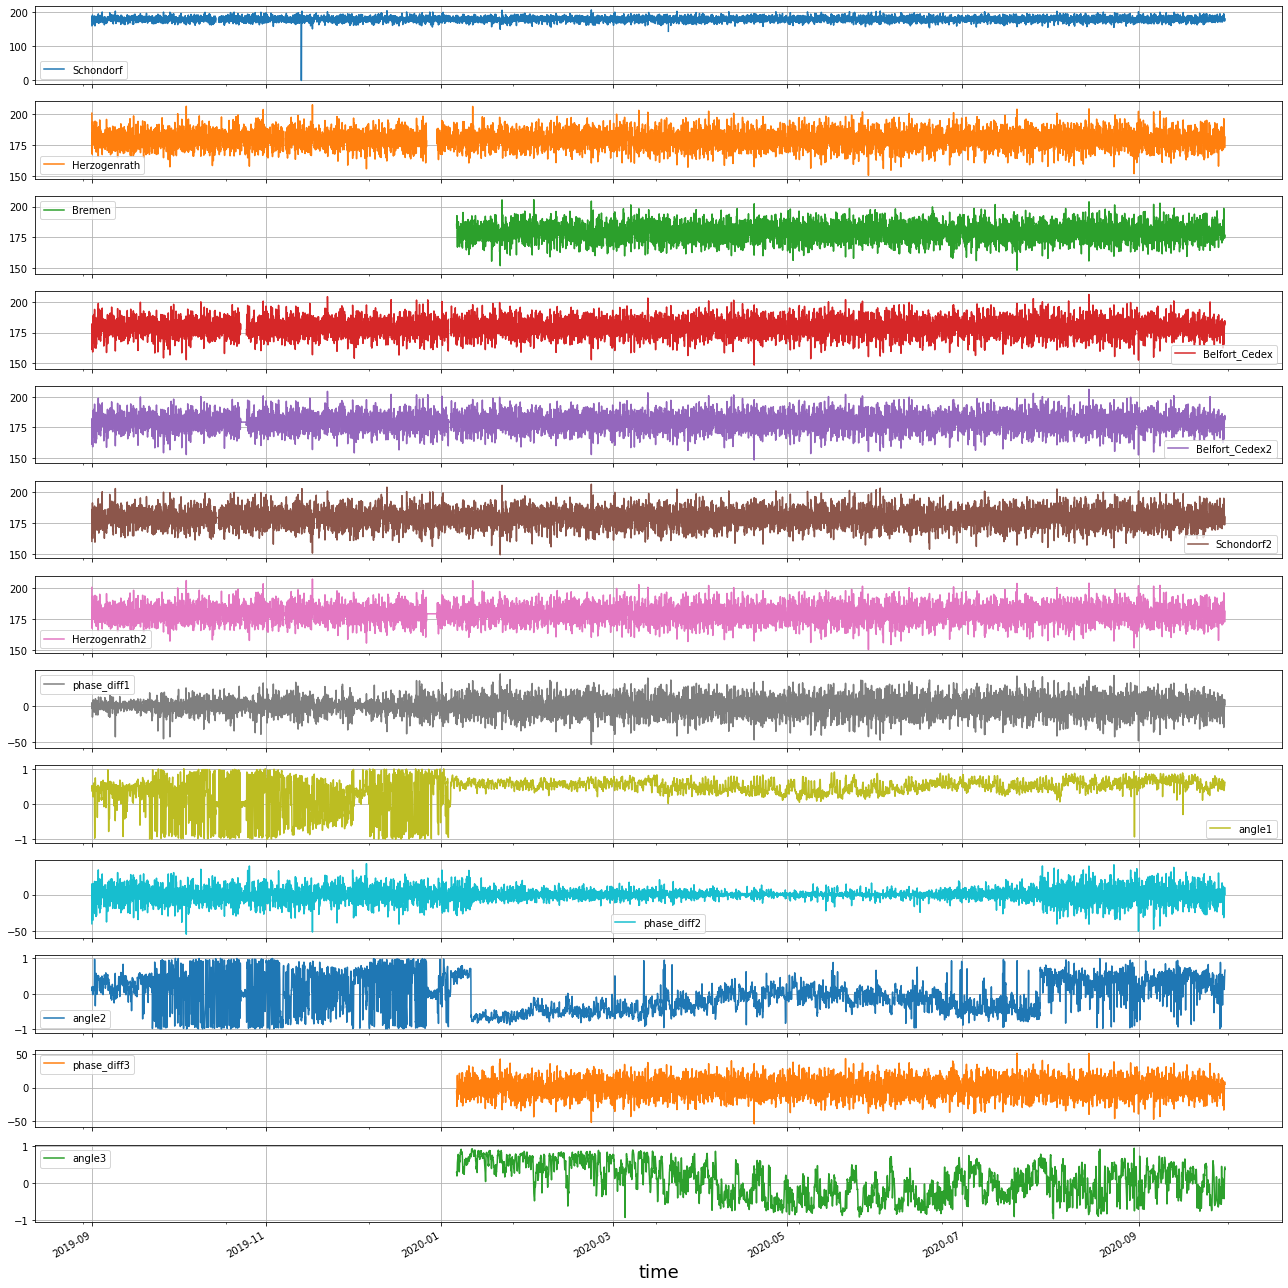

In [ ]:
%%time
phasor_data.plot(grid=True, subplots=True, figsize=(18,18))
plt.xlabel('time', fontsize=18)
plt.legend(loc='upper left')
plt.tight_layout()

In [ ]:
angle_data = phasor_data[['angle1', 'angle2', 'angle3']].copy()
#angle_data.head()

phasor = angle_data.copy()
phasor = phasor.reset_index()
time_df = (phasor['time'] >= ('2020-01-07 00:00:00')) & (phasor['time'] <= ('2020-09-30 23:45:00'))
phasor_df = phasor.loc[time_df]
phasor_df = phasor_df.set_index(['time'])


phasor_df.head()

,angle1,angle2,angle3
time,,,
2020-01-07 00:00:00,0.675285,0.707752,0.743627
2020-01-07 01:00:00,0.707331,0.728123,0.775235
2020-01-07 02:00:00,0.683352,0.680253,0.711087
2020-01-07 03:00:00,0.663806,0.678527,0.725584
2020-01-07 04:00:00,0.605416,0.698424,0.742759


In [ ]:
phasor_df.isna().sum()


angle1    0
angle2    0
angle3    0
dtype: int64

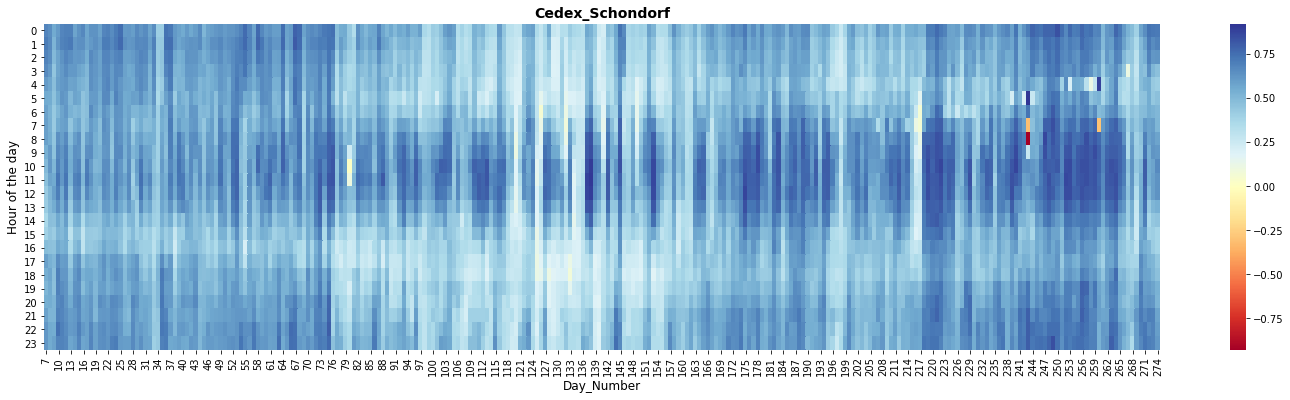

In [ ]:
heatmap_df1 = phasor_df.copy()

#Create variables for Day and hour
heatmap_df1['Day'] = [i.dayofyear for i in heatmap_df1.index]
heatmap_df1['hour'] = [i.hour for i in heatmap_df1.index]

#Group by day and hour and aggregate
heatmap_df1 = heatmap_df1.groupby(['Day','hour']).mean()

#Use unstack function to prepare the data to be plotted
heatmap_df1= heatmap_df1['angle1'].unstack(level=0)

fig1, ax = plt.subplots(figsize=(25, 6))

fig1.canvas.draw()
cmap = 'RdYlBu'


sns.heatmap(heatmap_df1, cmap=cmap)

#plt.title('Herzogenrath_Schondorf \n (Jan 2020 - Sept 2020)', fontweight='bold', fontsize = 14)
plt.title('Cedex_Schondorf', fontweight='bold', fontsize = 14)
plt.xlabel("Day_Number", fontsize=12)
plt.ylabel("Hour of the day", fontsize=12)

plt.yticks(rotation=0)
#plt.xticks('Day -' + from_jan_2020.Day)

labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[2] = 'Day -'

ax.set_xticklabels(labels)
plt.show()


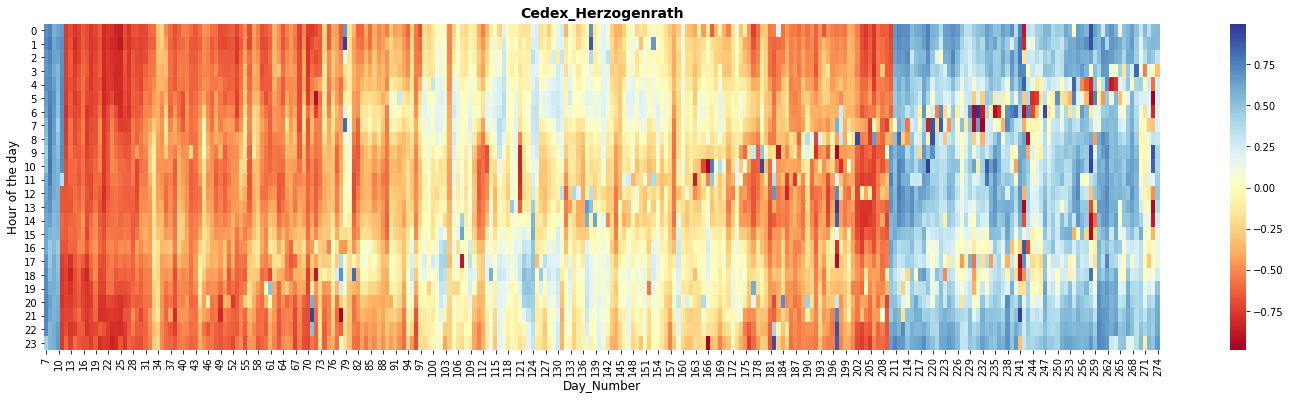

In [ ]:
heatmap_df2 = phasor_df.copy()

#Create variables for Day and hour
heatmap_df2['day'] = [i.dayofyear for i in heatmap_df2.index]
heatmap_df2['hour'] = [i.hour for i in heatmap_df2.index]

#Group by day and hour and aggregate
heatmap_df2 = heatmap_df2.groupby(['day','hour']).mean()

#Use unstack function to prepare the data to be plotted
heatmap_df2= heatmap_df2['angle2'].unstack(level=0)


fig2, ax = plt.subplots(figsize=(25, 6))

fig2.canvas.draw()
cmap = 'RdYlBu'


sns.heatmap(heatmap_df2, cmap=cmap)

#plt.title('Herzogenrath_Schondorf \n (Jan 2020 - Sept 2020)', fontweight='bold', fontsize = 14)
plt.title('Cedex_Herzogenrath', fontweight='bold', fontsize = 14)
plt.xlabel("Day_Number", fontsize=12)
plt.ylabel("Hour of the day", fontsize=12)

plt.yticks(rotation=0)
#plt.xticks('Day -' + from_jan_2020.Day)

labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[2] = 'Day -'

ax.set_xticklabels(labels)
plt.show()


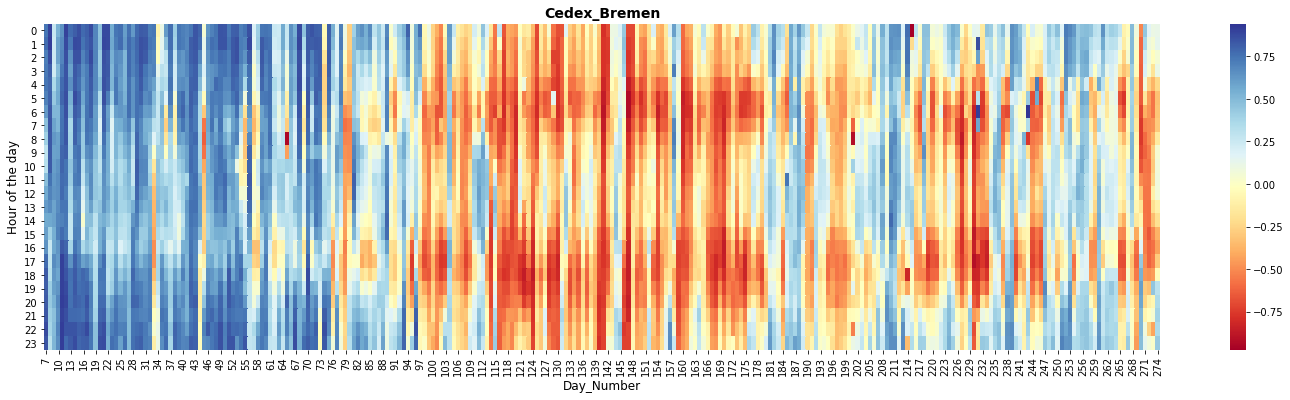

In [ ]:
heatmap_df3 = phasor_df.copy()

#Create variables for Day and hour
heatmap_df3['Day'] = [i.dayofyear for i in heatmap_df3.index]
heatmap_df3['hour'] = [i.hour for i in heatmap_df3.index]

#Group by day and hour and aggregate
heatmap_df3 = heatmap_df3.groupby(['Day','hour']).mean()


#Use unstack function to prepare the data to be plotted
heatmap_df3= heatmap_df3['angle3'].unstack(level=0)


fig3, ax = plt.subplots(figsize=(25, 6))

fig3.canvas.draw()
#cmap = 'YlGnBu'
#cmap = 'YlGnBu'
#cmap = 'YlOrBr'
#cmap = 'BuGn_r'
cmap = 'RdYlBu'


sns.heatmap(heatmap_df3, cmap=cmap)

#plt.title('Herzogenrath_Schondorf \n (Jan 2020 - Sept 2020)', fontweight='bold', fontsize = 14)
plt.title('Cedex_Bremen', fontweight='bold', fontsize = 14)
plt.xlabel("Day_Number", fontsize=12)
plt.ylabel("Hour of the day", fontsize=12)

plt.yticks(rotation=0)
#plt.xticks('Day -' + from_jan_2020.Day)

labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[2] = 'Day -'

ax.set_xticklabels(labels)
plt.show()


In [ ]:
path3 = '/content/drive/My Drive/Colab Notebooks/Cross Border 2020.csv'

In [ ]:
df_cr = pd.read_csv(path3)
df_cr

,Time (CET),BZN|FR > BZN|DE-LU [MW],BZN|DE-LU > BZN|FR [MW]
0,01.01.2020 00:00 - 01.01.2020 01:00,795.0,0.0
1,01.01.2020 01:00 - 01.01.2020 02:00,1077.0,0.0
2,01.01.2020 02:00 - 01.01.2020 03:00,971.0,0.0
3,01.01.2020 03:00 - 01.01.2020 04:00,1370.0,0.0
4,01.01.2020 04:00 - 01.01.2020 05:00,1575.0,0.0
...,...,...,...
8780,31.12.2020 19:00 - 31.12.2020 20:00,0.0,1581.0
8781,31.12.2020 20:00 - 31.12.2020 21:00,0.0,1462.0
8782,31.12.2020 21:00 - 31.12.2020 22:00,0.0,1380.0
8783,31.12.2020 22:00 - 31.12.2020 23:00,0.0,1291.0


In [ ]:
df_cr['BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW]'] = df_cr['BZN|DE-LU > BZN|FR [MW]']-df_cr['BZN|FR > BZN|DE-LU [MW]']
df_cr

,Time (CET),BZN|FR > BZN|DE-LU [MW],BZN|DE-LU > BZN|FR [MW],BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW]
0,01.01.2020 00:00 - 01.01.2020 01:00,795.0,0.0,-795.0
1,01.01.2020 01:00 - 01.01.2020 02:00,1077.0,0.0,-1077.0
2,01.01.2020 02:00 - 01.01.2020 03:00,971.0,0.0,-971.0
3,01.01.2020 03:00 - 01.01.2020 04:00,1370.0,0.0,-1370.0
4,01.01.2020 04:00 - 01.01.2020 05:00,1575.0,0.0,-1575.0
...,...,...,...,...
8780,31.12.2020 19:00 - 31.12.2020 20:00,0.0,1581.0,1581.0
8781,31.12.2020 20:00 - 31.12.2020 21:00,0.0,1462.0,1462.0
8782,31.12.2020 21:00 - 31.12.2020 22:00,0.0,1380.0,1380.0
8783,31.12.2020 22:00 - 31.12.2020 23:00,0.0,1291.0,1291.0


In [ ]:
print(df_cr.loc[[6576]])

                               Time (CET)  ...  BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW]
6576  01.10.2020 00:00 - 01.10.2020 01:00  ...                                           -962.0

[1 rows x 4 columns]


In [ ]:
df_cr

,Time (CET),BZN|FR > BZN|DE-LU [MW],BZN|DE-LU > BZN|FR [MW],BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW]
0,01.01.2020 00:00 - 01.01.2020 01:00,795.0,0.0,-795.0
1,01.01.2020 01:00 - 01.01.2020 02:00,1077.0,0.0,-1077.0
2,01.01.2020 02:00 - 01.01.2020 03:00,971.0,0.0,-971.0
3,01.01.2020 03:00 - 01.01.2020 04:00,1370.0,0.0,-1370.0
4,01.01.2020 04:00 - 01.01.2020 05:00,1575.0,0.0,-1575.0
...,...,...,...,...
8780,31.12.2020 19:00 - 31.12.2020 20:00,0.0,1581.0,1581.0
8781,31.12.2020 20:00 - 31.12.2020 21:00,0.0,1462.0,1462.0
8782,31.12.2020 21:00 - 31.12.2020 22:00,0.0,1380.0,1380.0
8783,31.12.2020 22:00 - 31.12.2020 23:00,0.0,1291.0,1291.0


In [ ]:
new_df= df_cr["Time (CET)"].str.split("-",n=1,expand= True)
df_cr["Date part "]=new_df[0]
df_cr["CET_Timestamp"]=new_df[1]


In [ ]:
df_cr['CET_Timestamp'] = df_cr['CET_Timestamp'].astype('datetime64[ns]')

In [ ]:
df_cr = df_cr.assign(Date= df_cr.CET_Timestamp.dt.date, Time = df_cr.CET_Timestamp.dt.time )
df_cr = df_cr.set_index (['CET_Timestamp'])

In [ ]:
df_cr.head(3)

,Time (CET),BZN|FR > BZN|DE-LU [MW],BZN|DE-LU > BZN|FR [MW],BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW],Date part,Date,Time
CET_Timestamp,,,,,,,
2020-01-01 01:00:00,01.01.2020 00:00 - 01.01.2020 01:00,795.0,0.0,-795.0,01.01.2020 00:00,2020-01-01,01:00:00
2020-01-01 02:00:00,01.01.2020 01:00 - 01.01.2020 02:00,1077.0,0.0,-1077.0,01.01.2020 01:00,2020-01-01,02:00:00
2020-01-01 03:00:00,01.01.2020 02:00 - 01.01.2020 03:00,971.0,0.0,-971.0,01.01.2020 02:00,2020-01-01,03:00:00


In [ ]:
pt_titanic = df_cr.pivot_table(index='Time', columns='Date', values='BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW]')

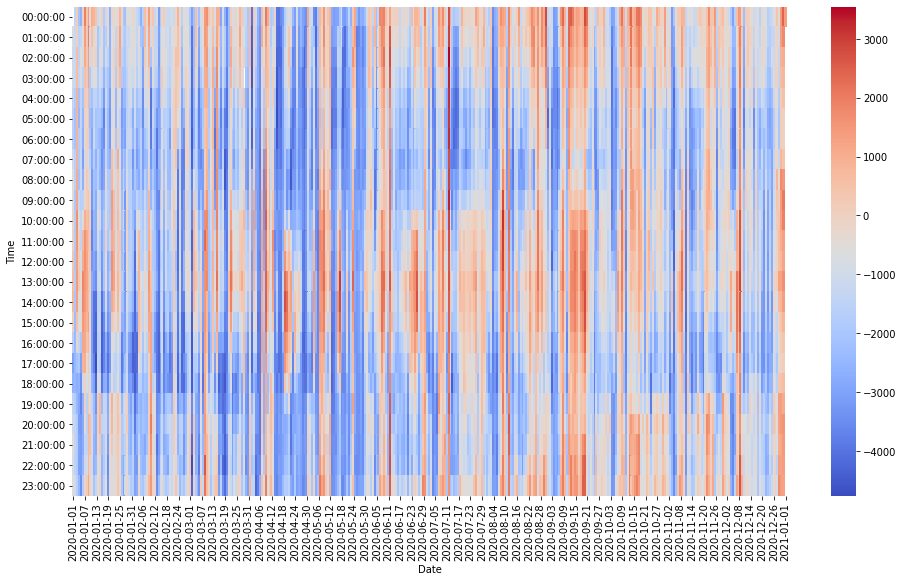

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(pt_titanic,cmap="coolwarm")

In [ ]:
df_cr['Year'] = df_cr.index.year
df_cr['Month'] = df_cr.index.month
df_cr['day'] = df_cr.index.day
# Display a random sampling of 5 rows
# df.sample(5, random_state=0)

In [ ]:
pt_titanic_2 = df_cr.pivot_table(index='Time', columns='Month', values='BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW]')

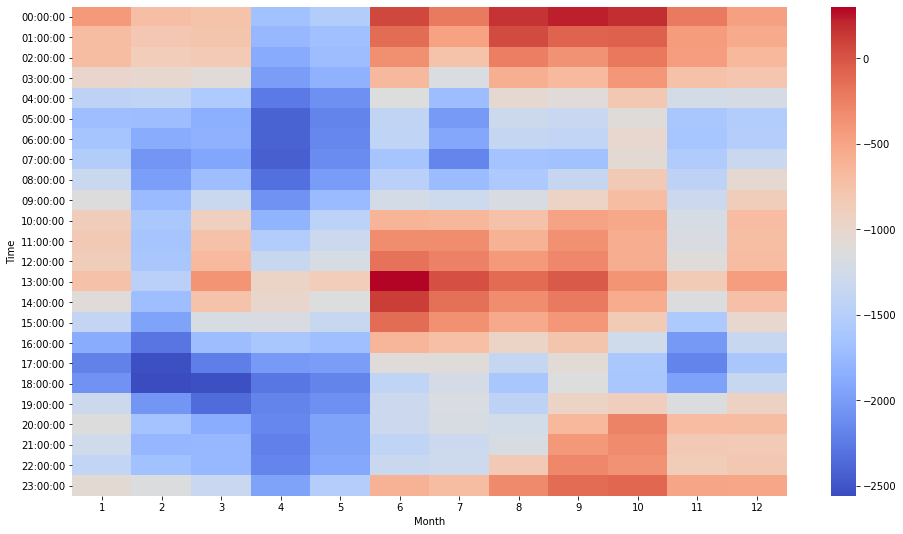

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(pt_titanic_2,cmap="coolwarm")

In [ ]:
energy = df_cr.copy()
energy = energy.reset_index()
time_series = (energy['CET_Timestamp'] >= ('2020-07-01 01:00:00')) & (energy['CET_Timestamp']<= ('2020-10-01 23:00:00'))
pv_df = energy.loc[time_series]
pv_df = pv_df.set_index(['CET_Timestamp'])
pv_df.head()

,Time (CET),BZN|FR > BZN|DE-LU [MW],BZN|DE-LU > BZN|FR [MW],BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW],Date part,Date,Time,Year,Month,day
CET_Timestamp,,,,,,,,,,
2020-07-01 01:00:00,07.01.2020 00:00 - 07.01.2020 01:00,0.0,17.0,17.0,07.01.2020 00:00,2020-07-01,01:00:00,2020,7,1
2020-07-01 02:00:00,07.01.2020 01:00 - 07.01.2020 02:00,0.0,449.0,449.0,07.01.2020 01:00,2020-07-01,02:00:00,2020,7,1
2020-07-01 03:00:00,07.01.2020 02:00 - 07.01.2020 03:00,0.0,336.0,336.0,07.01.2020 02:00,2020-07-01,03:00:00,2020,7,1
2020-07-01 04:00:00,07.01.2020 03:00 - 07.01.2020 04:00,123.0,0.0,-123.0,07.01.2020 03:00,2020-07-01,04:00:00,2020,7,1
2020-07-01 05:00:00,07.01.2020 04:00 - 07.01.2020 05:00,379.0,0.0,-379.0,07.01.2020 04:00,2020-07-01,05:00:00,2020,7,1


In [ ]:
pv_df.tail()

,Time (CET),BZN|FR > BZN|DE-LU [MW],BZN|DE-LU > BZN|FR [MW],BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW],Date part,Date,Time,Year,Month,day
CET_Timestamp,,,,,,,,,,
2020-09-12 19:00:00,09.12.2020 18:00 - 09.12.2020 19:00,0.0,920.0,920.0,09.12.2020 18:00,2020-09-12,19:00:00,2020,9,12
2020-09-12 20:00:00,09.12.2020 19:00 - 09.12.2020 20:00,0.0,1363.0,1363.0,09.12.2020 19:00,2020-09-12,20:00:00,2020,9,12
2020-09-12 21:00:00,09.12.2020 20:00 - 09.12.2020 21:00,0.0,1484.0,1484.0,09.12.2020 20:00,2020-09-12,21:00:00,2020,9,12
2020-09-12 22:00:00,09.12.2020 21:00 - 09.12.2020 22:00,0.0,1281.0,1281.0,09.12.2020 21:00,2020-09-12,22:00:00,2020,9,12
2020-09-12 23:00:00,09.12.2020 22:00 - 09.12.2020 23:00,0.0,809.0,809.0,09.12.2020 22:00,2020-09-12,23:00:00,2020,9,12


In [ ]:
data1 = phasor_data.copy()
data2 = pv_df.copy()
data1 = data1.reset_index()
data2 = data2.reset_index()

all_data = data1.merge(data2, left_on=['time'], right_on=['CET_Timestamp'], how='right')

In [ ]:
df = all_data.copy()
df.rename(columns = {'angle1':'phasor_diff1','angle2':'phasor_diff2','angle3':'phasor_diff3',
                   'BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW]': 'flows between DE and FR'}, inplace = True)

In [ ]:
corr = df.corr().loc[['phasor_diff1', 'phasor_diff2', 'phasor_diff3','flows between DE and FR'], ['phasor_diff1', 'phasor_diff2','phasor_diff3','flows between DE and FR']]
display(corr)

,phasor_diff1,phasor_diff2,phasor_diff3,flows between DE and FR
phasor_diff1,1.000000,0.255170,0.337272,0.293726
phasor_diff2,0.255170,1.000000,0.190848,0.115433
phasor_diff3,0.337272,0.190848,1.000000,0.283201
flows between DE and FR,0.293726,0.115433,0.283201,1.000000


In [ ]:
corr.style.background_gradient(cmap='coolwarm')

,phasor_diff1,phasor_diff2,phasor_diff3,flows between DE and FR
phasor_diff1,1.000000,0.255170,0.337272,0.293726
phasor_diff2,0.255170,1.000000,0.190848,0.115433
phasor_diff3,0.337272,0.190848,1.000000,0.283201
flows between DE and FR,0.293726,0.115433,0.283201,1.000000


In [ ]:
df.head()

,time,Schondorf,Herzogenrath,Bremen,Belfort_Cedex,Belfort_Cedex2,Schondorf2,Herzogenrath2,phase_diff1,phasor_diff1,phase_diff2,phasor_diff2,phase_diff3,phasor_diff3,CET_Timestamp,Time (CET),BZN|FR > BZN|DE-LU [MW],BZN|DE-LU > BZN|FR [MW],flows between DE and FR,Date part,Date,Time,Year,Month,day
0,2020-07-01 01:00:00,178.956111,180.439444,188.048611,175.505000,175.505000,178.956111,180.439444,-3.451111,0.603824,-4.934444,-0.594966,-12.543611,0.352795,2020-07-01 01:00:00,07.01.2020 00:00 - 07.01.2020 01:00,0.0,17.0,17.0,07.01.2020 00:00,2020-07-01,01:00:00,2020,7,1
1,2020-07-01 02:00:00,177.502222,181.024167,182.378333,183.842222,183.842222,177.502222,181.024167,6.340000,0.582898,2.818056,-0.523562,1.463889,0.218081,2020-07-01 02:00:00,07.01.2020 01:00 - 07.01.2020 02:00,0.0,449.0,449.0,07.01.2020 01:00,2020-07-01,02:00:00,2020,7,1
2,2020-07-01 03:00:00,182.316667,173.218333,183.503611,173.474444,173.474444,182.316667,173.218333,-8.842222,0.578370,0.256111,-0.534751,-10.029167,0.173846,2020-07-01 03:00:00,07.01.2020 02:00 - 07.01.2020 03:00,0.0,336.0,336.0,07.01.2020 02:00,2020-07-01,03:00:00,2020,7,1
3,2020-07-01 04:00:00,190.368333,171.175882,191.471111,170.164444,170.164444,190.368333,171.178168,-20.203889,0.480111,-1.013723,-0.520502,-21.306667,-0.060853,2020-07-01 04:00:00,07.01.2020 03:00 - 07.01.2020 04:00,123.0,0.0,-123.0,07.01.2020 03:00,2020-07-01,04:00:00,2020,7,1
4,2020-07-01 05:00:00,171.774722,185.174722,174.848611,188.409722,188.409722,171.774722,185.174722,16.635000,0.567139,3.235000,-0.365796,13.561111,-0.225828,2020-07-01 05:00:00,07.01.2020 04:00 - 07.01.2020 05:00,379.0,0.0,-379.0,07.01.2020 04:00,2020-07-01,05:00:00,2020,7,1


In [ ]:
new_df2 = df[['time', 'phasor_diff3', 'flows between DE and FR']].copy()
new_df2 = new_df2.set_index(['time'])
new_df2.head()

,phasor_diff3,flows between DE and FR
time,,
2020-07-01 01:00:00,0.352795,17.0
2020-07-01 02:00:00,0.218081,449.0
2020-07-01 03:00:00,0.173846,336.0
2020-07-01 04:00:00,-0.060853,-123.0
2020-07-01 05:00:00,-0.225828,-379.0


In [ ]:

# start and end dates of the time series
print ("Dataset: start_date = {}, end_date = {} \n".format(new_df2.index.min(), new_df2.index.max()))

Dataset: start_date = 2020-07-01 01:00:00, end_date = 2020-09-30 23:00:00 



In [ ]:

new_df2.describe()

,phasor_diff3,flows between DE and FR
count,2208.000000,2232.000000
mean,0.011753,-837.270609
std,0.372406,1588.567992
min,-0.972343,-4425.000000
25%,-0.276484,-2043.500000
50%,0.041999,-747.000000
75%,0.318264,320.000000
max,0.942492,3549.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


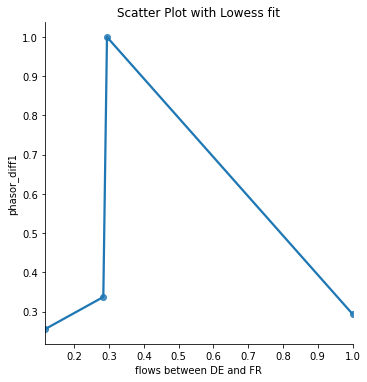

In [ ]:
sns.lmplot(x='flows between DE and FR', y= 'phasor_diff1', data=corr, lowess=True) 
plt.title("Scatter Plot with Lowess fit");

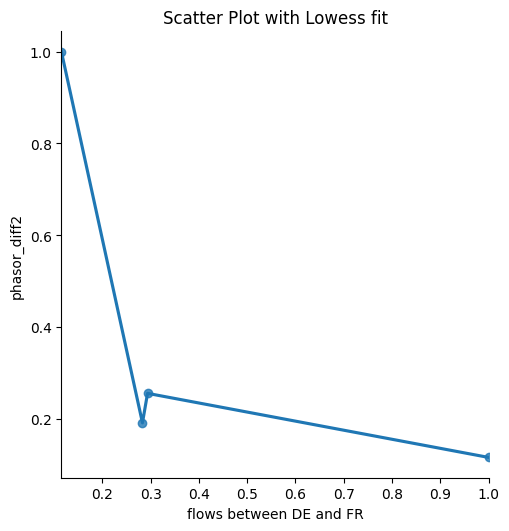

In [ ]:
sns.lmplot(x='flows between DE and FR', y= 'phasor_diff2', data=corr, lowess=True) 
plt.title("Scatter Plot with Lowess fit");

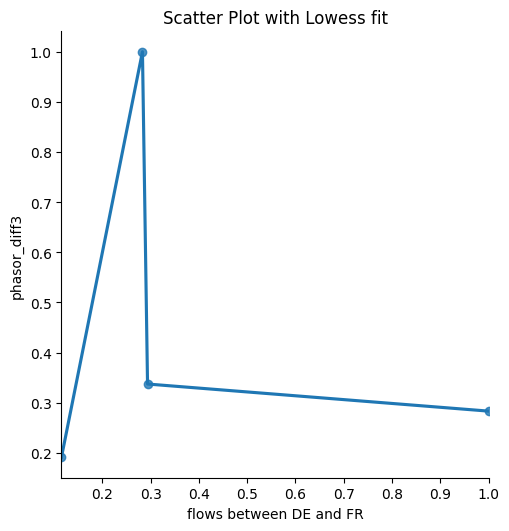

In [ ]:
sns.lmplot(x='flows between DE and FR', y= 'phasor_diff3', data=corr, lowess=True) 
plt.title("Scatter Plot with Lowess fit");

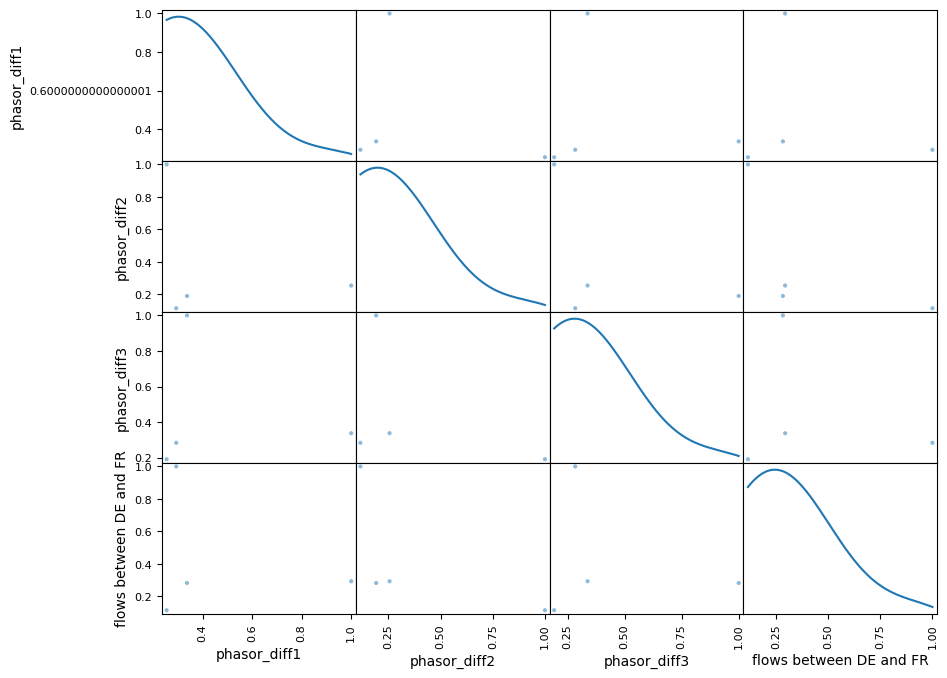

In [ ]:
scatter_matrix(corr,diagonal='kde')
plt.show()

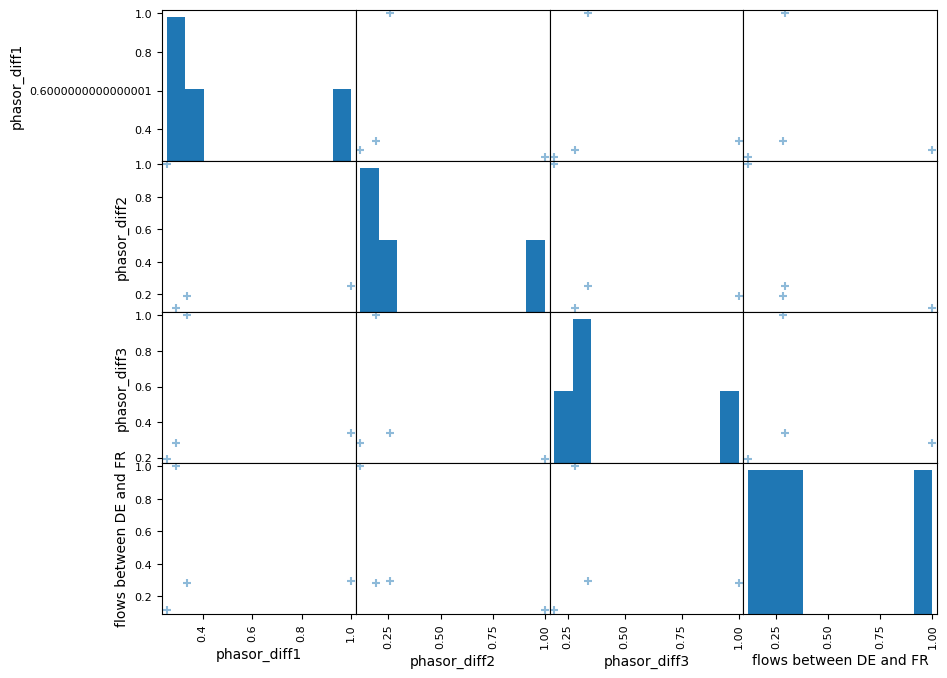

In [ ]:
scatter_matrix(corr,marker='+')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ce34a7c10>,
      dtype=object)

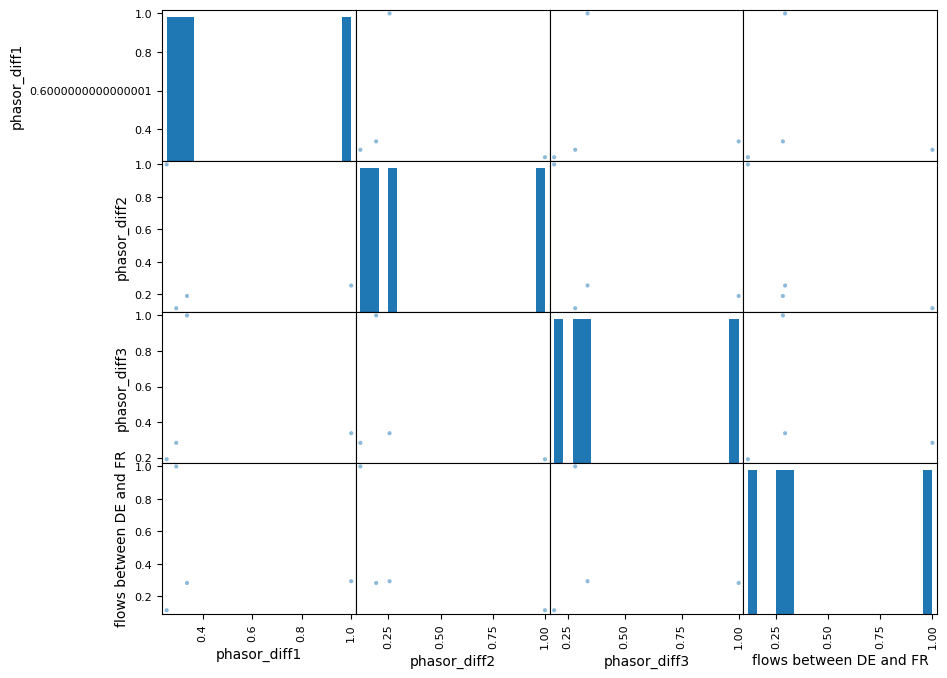

In [ ]:
scatter_matrix(corr, hist_kwds={'bins':20})

In [ ]:
#the supervised learning algorithm was adopted from
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
## Scale all features in range of [0,1].
values = new_df2.values 

#features normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# columns we don't need to predict are dropped
reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
#print(reframed.head())

In [ ]:
# split into train and test sets
values = reframed.values

train_size = int(len(values) * 0.67)
test_size = len(values) - train_size
train, test = values[0:train_size,:], values[train_size:len(scaled),:]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# The input is reshaped into a 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1478, 1, 2) (1478,) (728, 1, 2) (728,)


Epoch 1/20
22/22 [==============================] - 26s 65ms/step - loss: 0.2778 - val_loss: 0.2145
Epoch 2/20
22/22 [==============================] - 0s 10ms/step - loss: 0.1862 - val_loss: 0.0722
Epoch 3/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0630 - val_loss: 0.0219
Epoch 4/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0267 - val_loss: 0.0161
Epoch 5/20
22/22 [==============================] - 0s 12ms/step - loss: 0.0273 - val_loss: 0.0148
Epoch 6/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0249 - val_loss: 0.0137
Epoch 7/20
22/22 [==============================] - 0s 12ms/step - loss: 0.0230 - val_loss: 0.0122
Epoch 8/20
22/22 [==============================] - 0s 12ms/step - loss: 0.0217 - val_loss: 0.0109
Epoch 9/20
22/22 [==============================] - 0s 13ms/step - loss: 0.0194 - val_loss: 0.0098
Epoch 10/20
22/22 [==============================] - 0s 13ms/step - loss: 0.0181 - val_loss: 0.0086
Epoch 11/

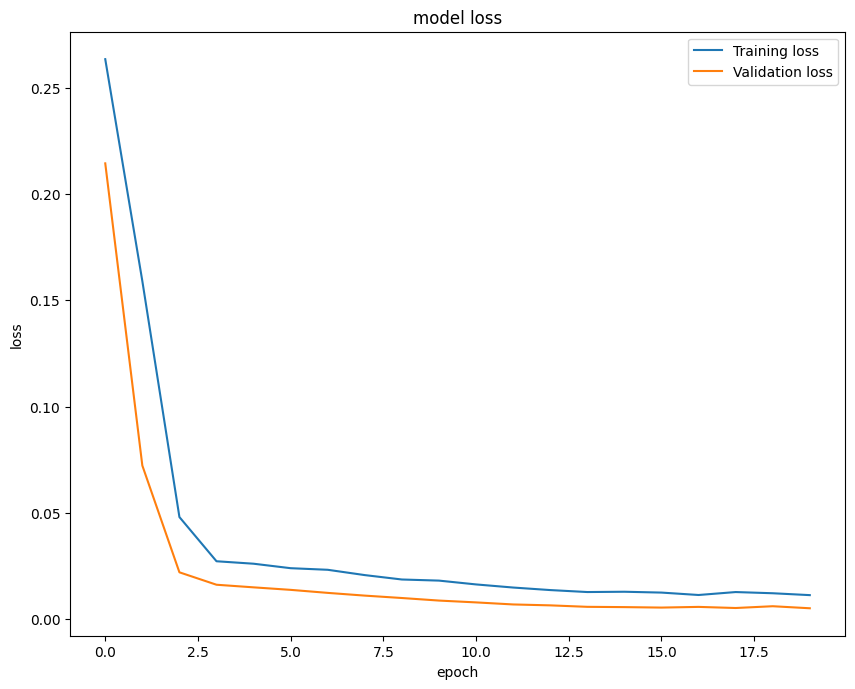

Train RMSE: 0.157
Train MAE: 0.106
Test RMSE: 0.135
Test MAE: 0.098


In [ ]:

model = Sequential()
model.add(LSTM(128, activation='relu',input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu',return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
#model.summary()

# fit model
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=1, shuffle=False)


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')

plt.show()

# make a prediction
vhat = model.predict(train_X) ## train
yhat = model.predict(test_X) ## test
test_X = test_X.reshape((test_X.shape[0], 2))
train_X = train_X.reshape((train_X.shape[0], 2))

# invert scaling for forecast (train)
inv_vhat = np.concatenate((vhat, train_X[:, -1:]), axis=1)
inv_vhat = scaler.inverse_transform(inv_vhat)
inv_vhat = inv_vhat[:,0]

# invert scaling for forecast (test)
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual (train)
train_y = train_y.reshape((len(train_y), 1))
inv2_y = np.concatenate((train_y, train_X[:, -1:]), axis=1)
inv2_y = scaler.inverse_transform(inv2_y)
inv2_y = inv2_y[:,0]

# invert scaling for actual (test)
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


# calculate RMSE and MAE train and test
rmse2 = np.sqrt(mean_squared_error(inv2_y, inv_vhat))
print('Train RMSE: %.3f' % rmse2)
mae2 = mean_absolute_error(inv2_y, inv_vhat)
print('Train MAE: %.3f' % mae2)

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

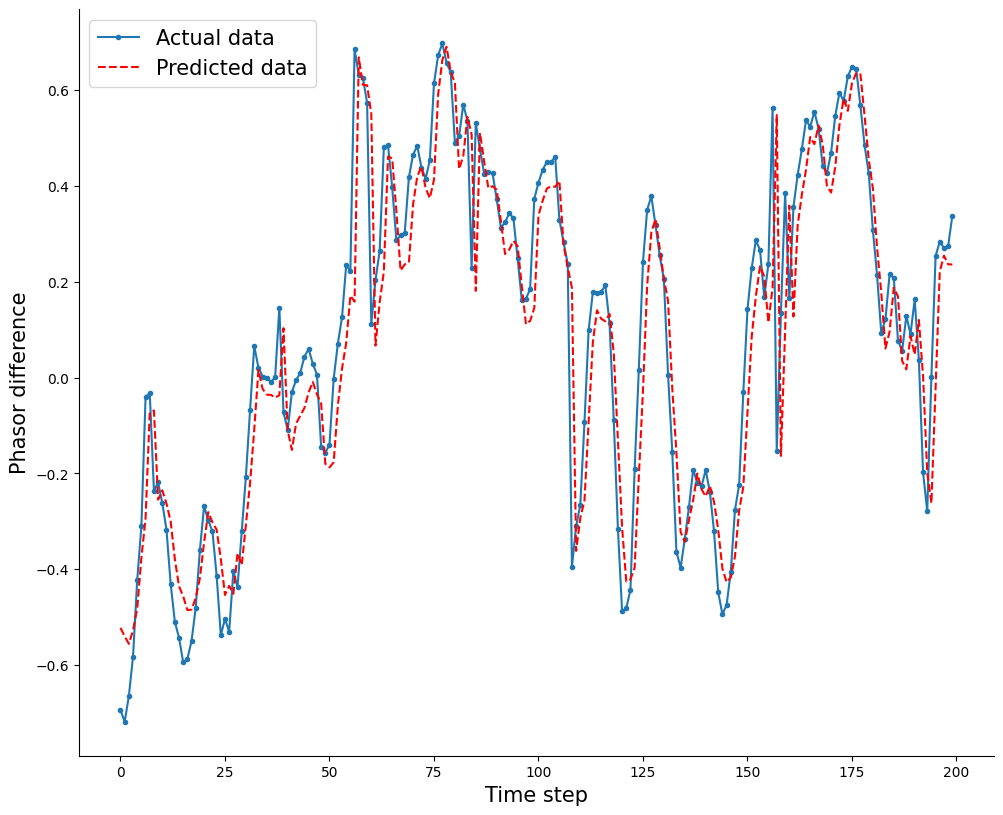

In [ ]:
## time steps, every step is 1 hr  (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in few steps. 

aa=[x for x in range(200)]

plt.plot(aa,inv_y[:200], marker='.', label="Actual data")
plt.plot(aa,inv_yhat[:200], '--r', label="Predicted data")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Phasor difference', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

plt.show()

In [ ]:

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns


new_df = new_df2.copy()
new_df_resample = new_df.resample('h').mean() 
new_df_resample = new_df_resample.reset_index(['time'])
#Separate dates for future plotting
train_dates = (new_df_resample['time'])

#Variables for training
cols = list(new_df_resample)[1:6]

df_for_training = new_df_resample[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
#features normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

trainX = []
trainY = []

n_future = 1   # Number of hours we want to predict into the future
n_past = 1     # Number of past hours we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


# define Autoencoder model

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
#model.summary()


# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1, shuffle=False)

#plt.plot(history.history['loss'], label='Training loss')
#plt.plot(history.history['val_loss'], label='Validation loss')
#plt.legend()
#plt.show()

#Forecasting...
#Start with the last hour in training data and predict future...
n_future= 72  #Redefining n_future to extend prediction dates beyond original n_future time...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1h').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 

#Perform inverse transformation to rescale back to original range
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

trainX shape == (2206, 1, 2).
trainY shape == (2206, 1).
Epoch 1/10
125/125 [==============================] - 5s 14ms/step - loss: 0.1808 - val_loss: 0.0165
Epoch 2/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0227 - val_loss: 0.0112
Epoch 3/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0149 - val_loss: 0.0084
Epoch 4/10
125/125 [==============================] - 1s 5ms/step - loss: 0.0109 - val_loss: 0.0063
Epoch 5/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0098 - val_loss: 0.0057
Epoch 6/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0091 - val_loss: 0.0058
Epoch 7/10
125/125 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0054
Epoch 8/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 9/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0086 - val_loss: 0.0057
Epoch 10/10
125/125 [=====================

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'time':np.array(forecast_dates), 'phasor_diff3':y_pred_future})
df_forecast['time']=pd.to_datetime(df_forecast['time'])


original = new_df_resample.loc[:,['time', 'phasor_diff3']]
original['time']=pd.to_datetime(original['time'])
#original = original.loc[original['time'] >= '2020-01-1']

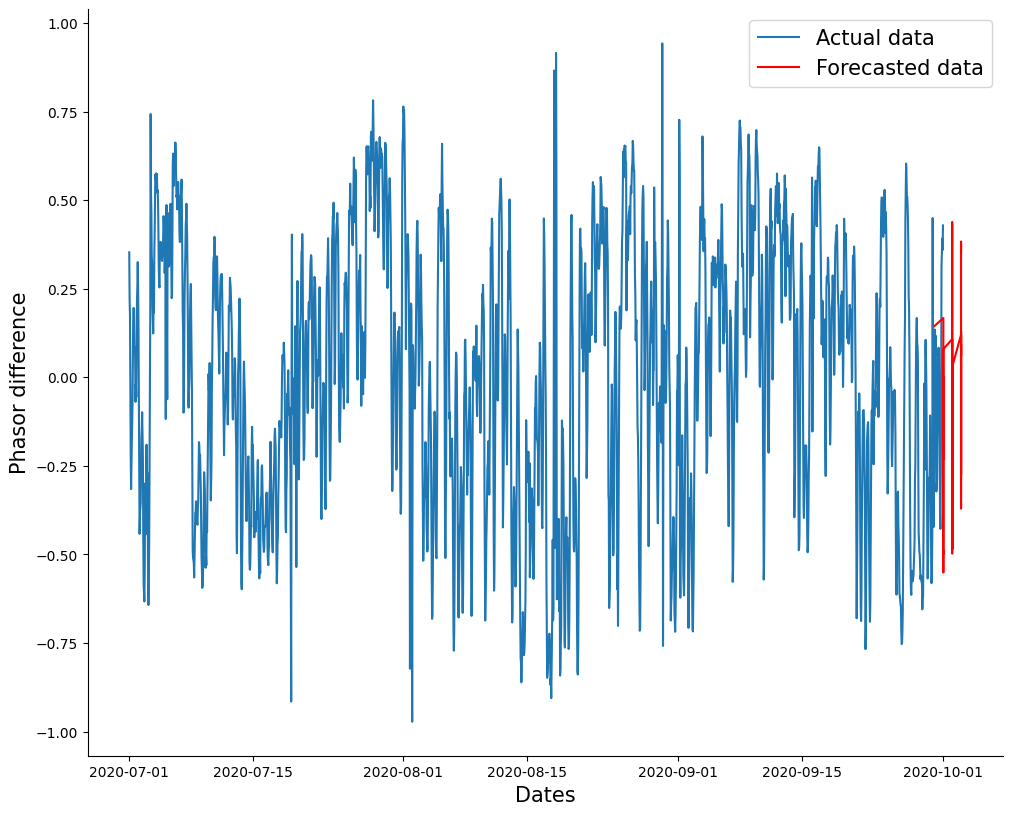

In [ ]:

plt.plot(original['time'],original['phasor_diff3'], marker='', label="Actual data")
plt.plot(df_forecast['time'],df_forecast['phasor_diff3'], 'r', label="Forecasted data")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Phasor difference', size=15)
plt.xlabel('Dates', size=15)
plt.legend(fontsize=15)

plt.show()

In [ ]:
   nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(2228, 25)
(4, 25)


In [ ]:
import statsmodels.api as sm
mdata = sm.datasets.macrodata.load_pandas().data
dates = mdata[['year']].astype(int).astype(str)
quarterly = dates["year"] 
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)
mdata = df[['phasor_diff1','phasor_diff2','flows between DE and FR']]
data = np.log(mdata).diff().dropna()
model = VAR(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, Jul, 2021
Time:                     13:52:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -5.89432
Nobs:                     414.000    HQIC:                  -6.01777
Log likelihood:          -478.926    FPE:                 0.00224619
AIC:                     -6.09853    Det(Omega_mle):      0.00213600
--------------------------------------------------------------------
Results for equation phasor_diff1
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             -0.023187         0.005056           -4.586           0.000
L1.phasor_diff1                    0.179193         0.051624            3.471           0.001
L

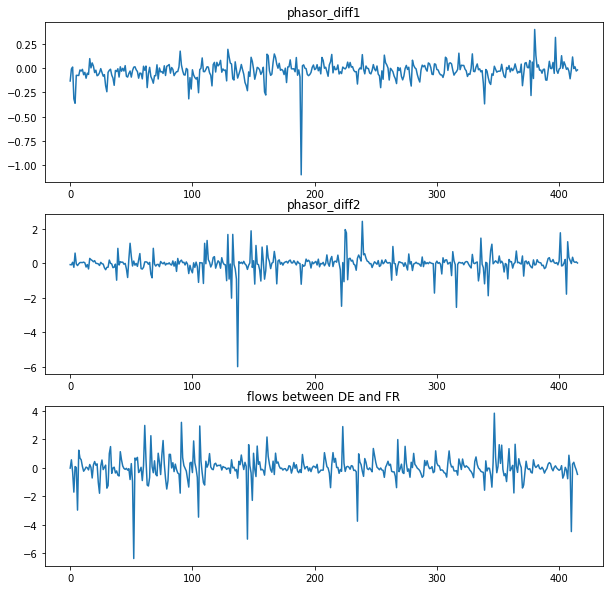

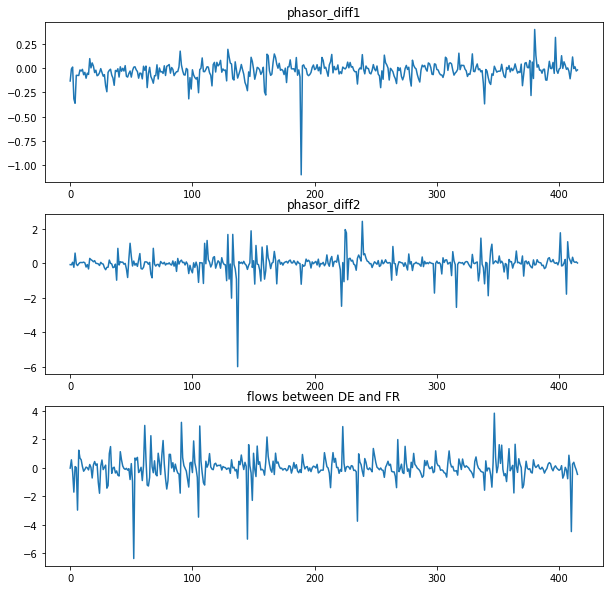

In [ ]:
results.plot()

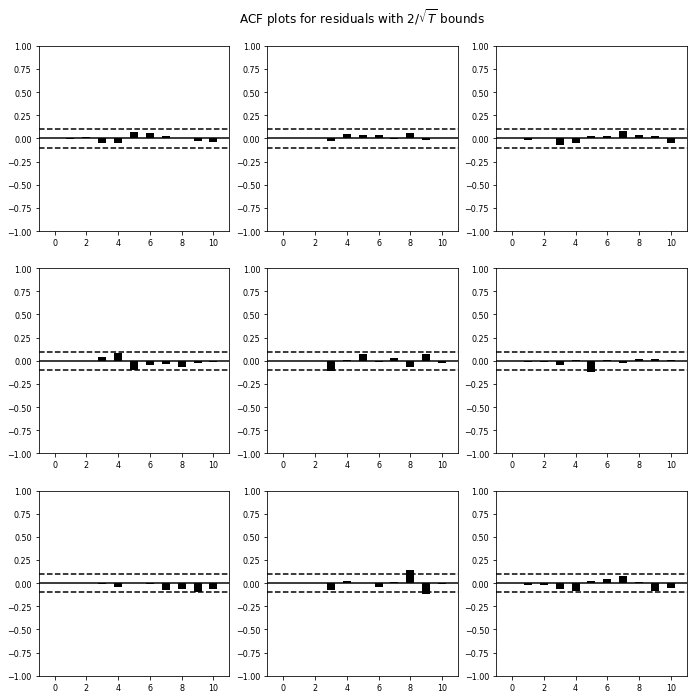

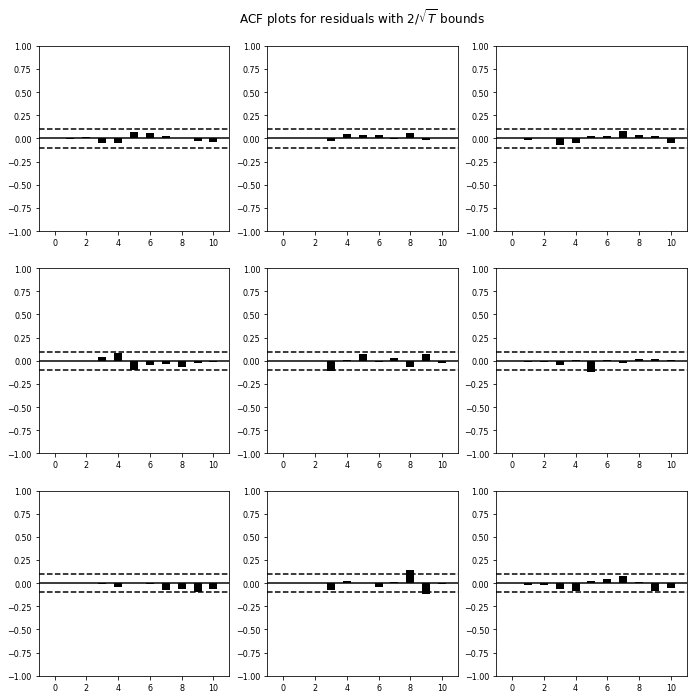

In [ ]:
results.plot_acorr()

In [ ]:
model.select_order(3)

In [ ]:
results = model.fit(maxlags=3, ic='aic')

In [ ]:
lag_order = results.k_ar

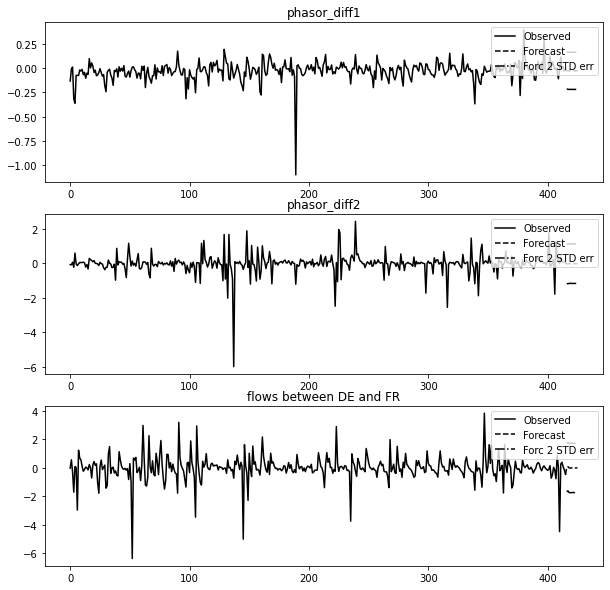

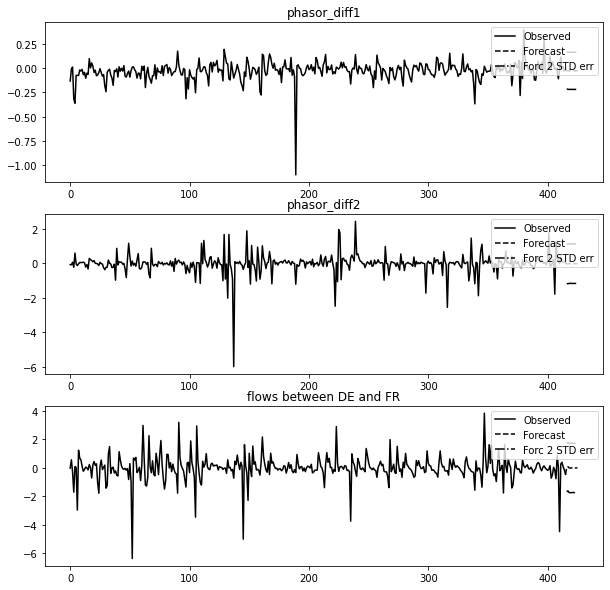

In [ ]:
results.plot_forecast(10)

In [ ]:
# ADF Test on each column
for name, column in df_tr_diff.iteritems():
   adfuller_test(column, name=column.name)

    Augmented Dickey-Fuller Test on "phasor_diff1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.6482
 No. Lags Chosen       = 26
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "phasor_diff2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.0597
 No. Lags Chosen       = 23
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "flows between DE and FR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

In [ ]:
#Fit VAR model
var_model = VAR(endog=df_tr_diff)
var_model_fit = var_model.fit(maxlags=10)
#Print a summary of the model results
var_model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, Jul, 2021
Time:                     14:08:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    4.24617
Nobs:                     2191.00    HQIC:                   4.09287
Log likelihood:          -13620.7    FPE:                    54.8482
AIC:                      4.00456    Det(Omega_mle):         52.5845
--------------------------------------------------------------------
Results for equation phasor_diff1
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               0.000296         0.001577            0.188           0.851
L1.phasor_diff1                    -0.066146         0.021814           -3.032           0.0

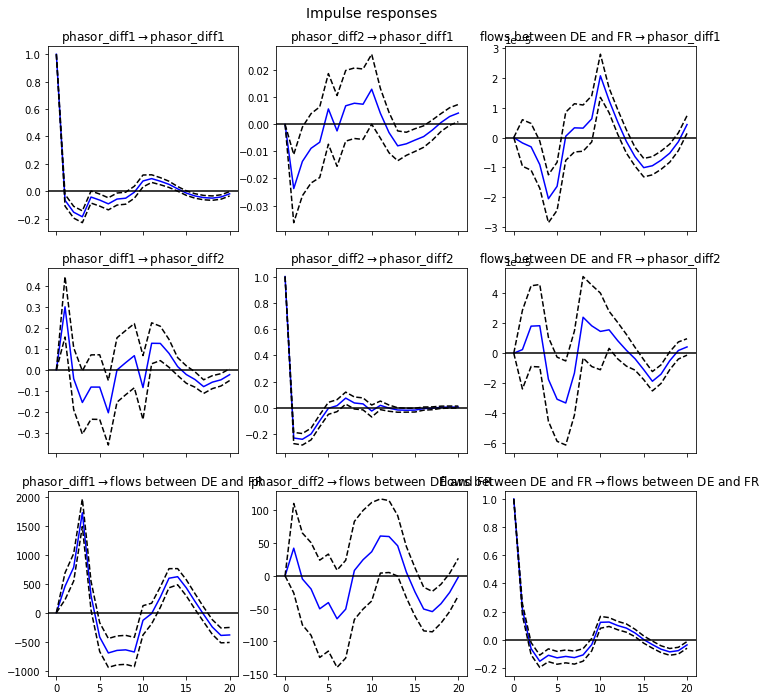

In [ ]:
# Impulse Response Analysis
irf = var_model_fit.irf(20)
irf.plot()
plt.show()

In [ ]:
# Get the lag order
lag_order = var_model_fit.k_ar
print(lag_order)
# Input data for forecasting
input_data = df_tr_diff.values[-lag_order:]
print(input_data)
# forecasting
pred = var_model_fit.forecast(y=input_data, steps=nobs)
pred = (pd.DataFrame(pred, index=df_test.index, columns= df.columns + '_pred'))
print(pred)

10
[[ 5.05613519e-02  4.51497928e-03 -3.36000000e+02]
 [ 2.47482827e-02  1.14933657e-01  1.80000000e+01]
 [-1.16475720e-02 -4.99015982e-01 -7.70000000e+01]
 [ 8.86742869e-04  2.43293567e-01 -2.45000000e+02]
 [-2.66876911e-02  1.34843298e-01  3.04000000e+02]
 [-8.46312717e-02  7.44744910e-02  2.10000000e+01]
 [-1.26593672e-02 -1.46197716e-02 -5.31000000e+02]
 [-3.95125113e-02 -2.24836467e-01 -1.42000000e+02]
 [-3.68594592e-02 -6.33664868e-02  5.80000000e+01]
 [ 6.90710331e-02  6.79624107e-02  7.84000000e+02]]
      phasor_diff1_pred  phasor_diff2_pred  flows between DE and FR_pred
2227           0.030363           0.081645                     91.687757
2228           0.023807           0.068559                    -45.027498
2229          -0.011186           0.063057                     46.682322
2230          -0.009237          -0.019180                     63.858608
2231          -0.002172          -0.049546                     74.818327
